### MNIST torch stuff

In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
## load mnist dataset

root = './data'
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor()])
# if not exist, download mnist dataset
train_set = torchvision.datasets.MNIST(root=root, train=True, transform=trans, download=True)
test_set = torchvision.datasets.MNIST(root=root, train=False, transform=trans, download=True)


In [2]:
train_set[0][0].size()

torch.Size([1, 28, 28])

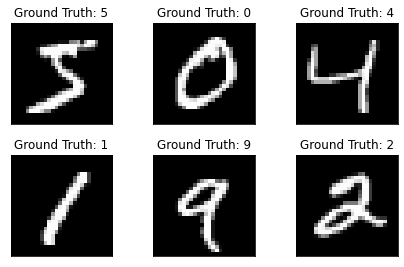

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(train_set[i][0].detach().numpy().squeeze(), cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(train_set[i][1]))
  plt.xticks([])
  plt.yticks([])

In [4]:
class MNISTConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 3, 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 2),
            nn.ReLU(),
            nn.Conv2d(64, 10, 2, 2)
        )

    def forward(self, x):
        out = self.net(x).view(x.size(0), -1)
        return out

In [5]:
target_network = MNISTConvNet()
pytorch_total_params = sum(p.numel() for p in target_network.parameters() if p.requires_grad)
pytorch_total_params

77066

### Hypernetwork

In [6]:
from hypernn.torch.hypernet import TorchHyperNetwork
from hypernn.torch.weight_generator import TorchWeightGenerator
from hypernn.torch.embedding_module import TorchEmbeddingModule

In [7]:
class StaticEmbeddingModule(TorchEmbeddingModule):
    def __init__(self, embedding_dim: int, num_embeddings: int):
        super().__init__(embedding_dim, num_embeddings)
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self):
        indices = torch.arange(self.num_embeddings).to(self.device)
        return self.embedding(indices)


class StaticWeightGenerator(TorchWeightGenerator):
    def __init__(self, embedding_dim: int, hidden_dim: int):
        super().__init__(embedding_dim, hidden_dim)
        self.embedding_network = nn.Sequential(
            nn.Linear(embedding_dim, 32),
            nn.Tanh(),
            nn.Linear(32, hidden_dim, bias=False),
        )

    def forward(self, embedding: torch.Tensor) -> torch.Tensor:
        return self.embedding_network(embedding).view(-1)


In [8]:
hypernetwork = TorchHyperNetwork(
                            target_network,
                            embedding_module_constructor=StaticEmbeddingModule,
                            weight_generator_constructor=StaticWeightGenerator,
                            embedding_dim = 16,
                            num_embeddings = 256
                        )
pytorch_total_params = sum(p.numel() for p in hypernetwork.parameters() if p.requires_grad)
pytorch_total_params

14320

In [9]:
device = torch.device('cuda')
hypernetwork = hypernetwork.to(device)

In [10]:
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=32,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=32,
                shuffle=False)

In [11]:
import tqdm
import numpy as np

optimizer = optim.Adam(hypernetwork.parameters(), lr=0.0002)
bar = tqdm.tqdm(np.arange(1000))
for i in bar:

    train_loss = []
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        out, _ = hypernetwork(x.to(hypernetwork.device))
        loss =  F.cross_entropy(out.to(hypernetwork.device), target.to(hypernetwork.device))
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    avg_loss = np.mean(train_loss)
    num_correct = 0
    count = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        count += x.size(0)
        with torch.no_grad():
            out, _ = hypernetwork(x.to(hypernetwork.device))
            _, predicted = torch.max(out.detach(), -1)
        num_correct += (predicted.detach().cpu() == target.data).sum()
    accuracy = num_correct / count
    bar.set_description("Loss: {}, Test Acc: {}".format(avg_loss, accuracy))


Loss: 0.0022594625438181093, Test Acc: 0.9854999780654907: 100%|██████████| 1000/1000 [3:03:11<00:00, 10.99s/it] 
